In [10]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda")
print(DEVICE)

cuda


In [11]:
image_size = 64
transform = transforms.Compose([
    #width to 64 since it was rectangle
    transforms.Resize(64),
    #centralize 
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    #normalize to range -1 to 1 due to tanh range
    transforms.Normalize(mean=[0.5]*3,std=[0.5]*3),
])

trainset = torchvision.datasets.CelebA(root='data', split='train', transform=transform, download=True)



#how does gan works


Files already downloaded and verified


Trainset size: 162770
Image size: torch.Size([3, 64, 64])


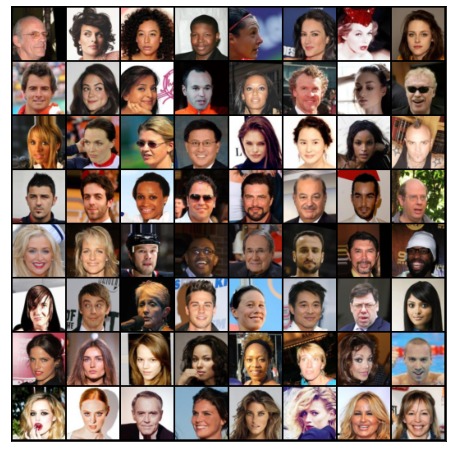

In [12]:
batch_size = 64

from torchvision.utils import make_grid

def draw_image(images, save=None, win_size=8):
    fig, ax = plt.subplots(figsize=(win_size,win_size))
    ax.set_xticks([])
    ax.set_yticks([])
    grid_image = make_grid(images.cpu().detach()[:win_size**2] * 0.5 + 0.5, nrow=win_size)
    grid_image = grid_image.permute(1, 2, 0)
    # change 3 64 64 to 64 64 3 since rgb at the end for graphing
    if save:
      print('Save images in', save)
      plt.imsave(save, grid_image.numpy())
    ax.imshow(grid_image)
    plt.show()

def show_batch(dl, save=None, win_size=8):
  for images, _ in dl:
    draw_image(images, save, win_size)
    break

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)
print("Trainset size:", len(trainset))
print("Image size:", trainset[0][0].shape)
show_batch(trainloader)
# train data example picture

In [13]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
).cuda()


summary(discriminator, input_size=(batch_size, 3, image_size, image_size))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1]                   --
├─Conv2d: 1-1                            [64, 64, 32, 32]          3,072
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]          128
├─LeakyReLU: 1-3                         [64, 64, 32, 32]          --
├─Conv2d: 1-4                            [64, 128, 16, 16]         131,072
├─BatchNorm2d: 1-5                       [64, 128, 16, 16]         256
├─LeakyReLU: 1-6                         [64, 128, 16, 16]         --
├─Conv2d: 1-7                            [64, 256, 8, 8]           524,288
├─BatchNorm2d: 1-8                       [64, 256, 8, 8]           512
├─LeakyReLU: 1-9                         [64, 256, 8, 8]           --
├─Conv2d: 1-10                           [64, 512, 4, 4]           2,097,152
├─BatchNorm2d: 1-11                      [64, 512, 4, 4]           1,024
├─LeakyReLU: 1-12                        [64, 512, 4, 4]   

In [14]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
).cuda()

summary(generator, input_size=(batch_size, latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 3, 64, 64]           --
├─ConvTranspose2d: 1-1                   [64, 512, 4, 4]           1,048,576
├─BatchNorm2d: 1-2                       [64, 512, 4, 4]           1,024
├─ReLU: 1-3                              [64, 512, 4, 4]           --
├─ConvTranspose2d: 1-4                   [64, 256, 8, 8]           2,097,152
├─BatchNorm2d: 1-5                       [64, 256, 8, 8]           512
├─ReLU: 1-6                              [64, 256, 8, 8]           --
├─ConvTranspose2d: 1-7                   [64, 128, 16, 16]         524,288
├─BatchNorm2d: 1-8                       [64, 128, 16, 16]         256
├─ReLU: 1-9                              [64, 128, 16, 16]         --
├─ConvTranspose2d: 1-10                  [64, 64, 32, 32]          131,072
├─BatchNorm2d: 1-11                      [64, 64, 32, 32]          128
├─ReLU: 1-12                             [64, 64, 32, 3

In [15]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=0.00025, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=0.00025, betas=(0.5, 0.999))
criterion = nn.BCELoss()

100%|██████████| 2544/2544 [03:11<00:00, 13.30it/s]


Epoch 0, G loss = 4.5531810736342235, D loss = 0.5852413123341551
Save images in GAN_vis/epoch_0.jpg


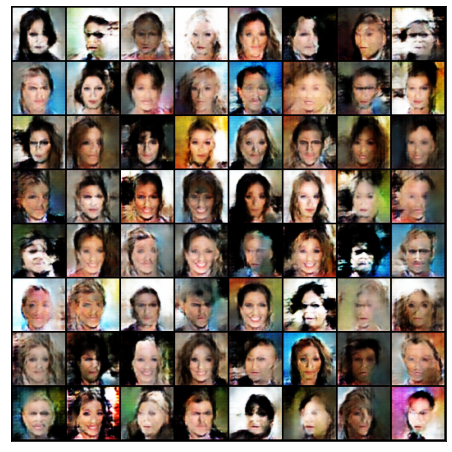

100%|██████████| 2544/2544 [03:19<00:00, 12.78it/s]


Epoch 1, G loss = 3.789222228780108, D loss = 0.5124328297902625
Save images in GAN_vis/epoch_1.jpg


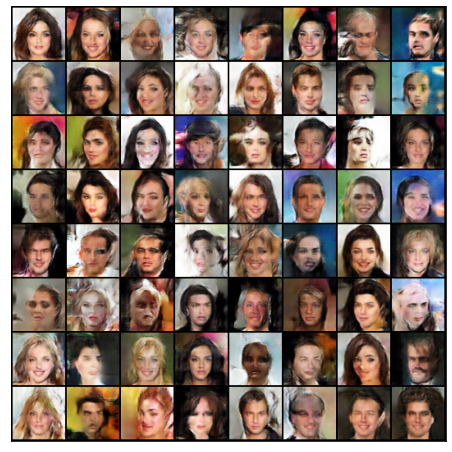

100%|██████████| 2544/2544 [03:19<00:00, 12.75it/s]


Epoch 2, G loss = 3.7276574311698876, D loss = 0.46173141542207097
Save images in GAN_vis/epoch_2.jpg


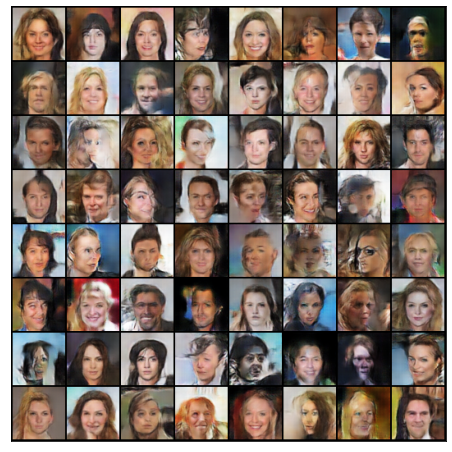

100%|██████████| 2544/2544 [03:19<00:00, 12.74it/s]


Epoch 3, G loss = 3.8483759610593005, D loss = 0.4154821130309441
Save images in GAN_vis/epoch_3.jpg


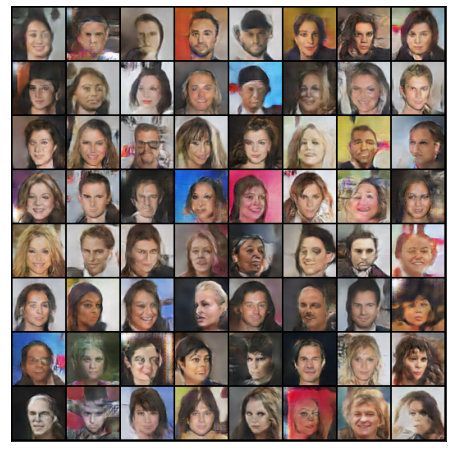

100%|██████████| 2544/2544 [03:28<00:00, 12.20it/s]


Epoch 4, G loss = 3.8018395158135676, D loss = 0.41040393487263305
Save images in GAN_vis/epoch_4.jpg


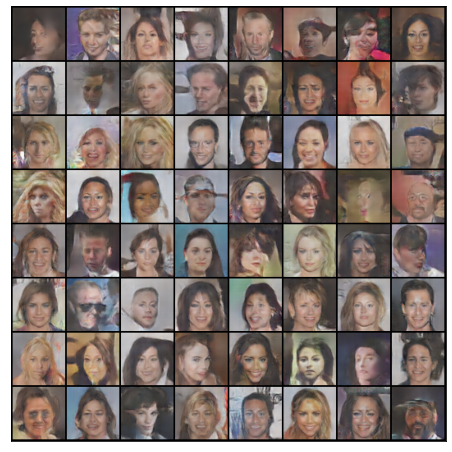

100%|██████████| 2544/2544 [03:19<00:00, 12.76it/s]


Epoch 5, G loss = 3.9378865419765465, D loss = 0.3642067436257717
Save images in GAN_vis/epoch_5.jpg


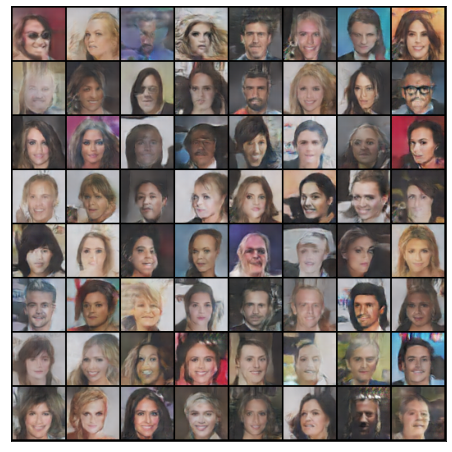

100%|██████████| 2544/2544 [03:18<00:00, 12.84it/s]


Epoch 6, G loss = 3.9172521933410365, D loss = 0.38499768375003207
Save images in GAN_vis/epoch_6.jpg


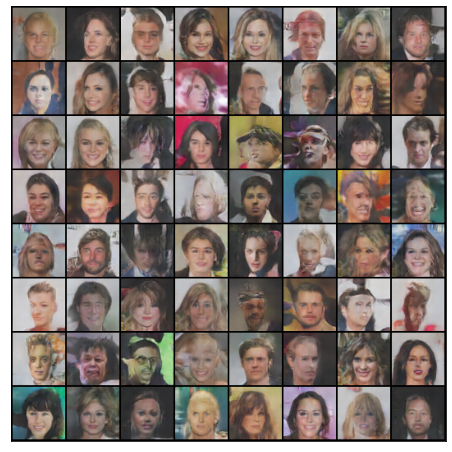

100%|██████████| 2544/2544 [03:18<00:00, 12.82it/s]


Epoch 7, G loss = 4.125003498297718, D loss = 0.3422146636535818
Save images in GAN_vis/epoch_7.jpg


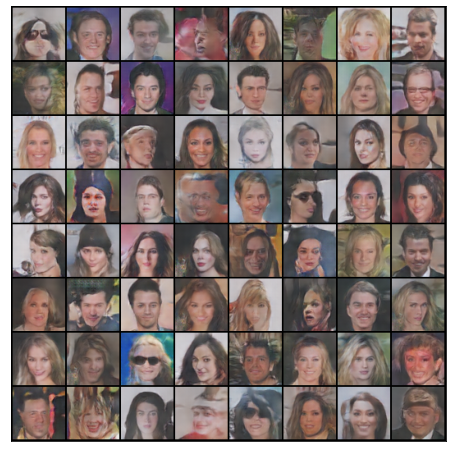

 82%|████████▏ | 2093/2544 [02:43<00:35, 12.81it/s]


KeyboardInterrupt: 

In [16]:
for epoch in range(100):
  total_loss_d, total_loss_g, now_iter = 0, 0, 0
  for cur_iter, (images, _) in tqdm(enumerate(trainloader), total=len(trainloader)):
    cur_batch_size = images.shape[0]
    images = images.cuda()

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(cur_batch_size, 1).cuda()
    fake_labels = torch.zeros(cur_batch_size, 1).cuda()

    # ==================== #
    # Train Discriminator #
    # ==================== #

    # z = Random sample from normal distribution, shape (batch_size, 128, 1, 1)
    z = torch.randn(cur_batch_size, 128, 1, 1).cuda()
    # fake_image = G(z) 
    # D Loss from fake image: BCE(D(fake_image), 0) -> target: fake's score 0 
    # D Loss from real image: BCE(D(real_image), 1) -> target: real's score 1
    d_loss_fake = criterion(discriminator(generator(z)), fake_labels)  
    d_loss_real = criterion(discriminator(images), real_labels)
    loss_d = d_loss_real + d_loss_fake

    # clean the gradient, backward and update parameters in discriminator.
    opt_d.zero_grad()
    loss_d.backward()
    opt_d.step()

    # ==================== #
    #    Train Generator   #
    # ==================== #

    # z = Random sample from normal distribution, shape (batch_size, latent_size)
    z = torch.randn(cur_batch_size, latent_size, 1, 1).cuda()
    fake_image = generator(z)
    # G Loss from fake image: BCE(D(fake_image), 1) -> target: fake's score 1
    # Which means G want to fool D
    loss_g = criterion(discriminator(fake_image), real_labels)

    # clean the gradient, backward and update parameters in generator.
    opt_g.zero_grad()
    loss_g.backward()
    opt_g.step()

    # ==================== #
    #   Update Statistics  #
    # ==================== #

    total_loss_d += loss_d.item()
    total_loss_g += loss_g.item()
    now_iter += 1
  print(f"Epoch {epoch}, G loss = {total_loss_g / now_iter}, D loss = {total_loss_d / now_iter}")

  # Draw images
  with torch.no_grad():
    z = torch.randn(batch_size, latent_size, 1, 1).cuda()
    fake_image = generator(z)

  draw_image(fake_image, f"GAN_vis/epoch_{epoch}.png")
  if epoch % 5 == 0:
    torch.save(discriminator, 'GAN_models/discriminator')
    torch.save(generator, 'GAN_models/generator')
    